In [8]:
import numpy as np
import logging 
import time 
from datetime import datetime
import json
from pathlib import Path

from src import ParameterSet, Plot
from src import ModelBase as Model
from src.integral import itoint

from src.model_base import ModelBase
import matplotlib.pyplot as plt

# np.seterr(all='raise')
np.set_printoptions(precision=4, suppress=True, linewidth=200)
logging.basicConfig(level=logging.WARN)

In [17]:
def run(t_end, changes = {}, *, dt=0.001, path:Path=None):
    #print(f'estimated time: {1.1 * t_end/dt / 1000} seconds')
    t_start = time.time()
    t = np.linspace(0, t_end, int(t_end / dt) + 1)
    y0 = Model()
    y0.initialize()
    #params = ParameterSet("structure.json")
    params = ParameterSet("smallcirtuit.json")
    params.batch_update(changes)
    #params.J.print_matrix()
    #params.J_ampa.print_matrix()
    #print(json.dumps(params.__flat_json__(ignore_zeros=True), indent=2))
    if path is not None:
        params.save(path / 'params.json')
        params.saveDelta(path / 'params_delta.json',base_file='structure.json')
        params.saveDeltaHtml(path / 'params_delta.html',base_file='structure.json')
        params.saveHtml(path / 'params.html',keys = [])

    def calc_g_static():
      sigma = y0.serialize_g(params)
      g_vector = sigma * params.constants.tau_y
      g_matrix = np.diag(g_vector)
      g_matrix = g_matrix[:,~np.all(g_matrix == 0, axis=0)]
      g_matrix = g_matrix * 1.0
      return g_matrix
    
    g_matrix = calc_g_static()

    def model_f(y, t):
        Y = Model().deserialize(y)
        delta = Y.calcDelta(t, params)
        dy = delta.serialize()
        return dy

    def model_g(y, t):
        # Y = MyState().deserialize(y)
        # sigma = Y.serialize_g(params)
        # tau_y = params.constants.tau_y
        # g = sigma * tau_y
        # return np.diag(g_vector)
        return g_matrix.copy()

    # gen = np.random.Generator(np.random.PCG64(123))
    gen = None
    # res = sdeint.itoint(model_f, model_g, y0.serialize(), t, gen)
    res = itoint(model_f, model_g, y0.serialize(), t, gen)
    def toState(y): return Model().deserialize(y)
    t_end = time.time()
    #print(f'elapsed time: {t_end - t_start} seconds')
    return t, list(map(toState, res))

In [10]:
new_params = {"sst1.I_back.dc": 0.25,"sst2.I_back.dc": 0.25,
                "vip1.I_back.type": "sin", "vip1.I_back.amplitude": 0.1, 
                "vip1.I_back.frequency": 4, "vip2.I_back.type": "sin", 
                "vip2.I_back.amplitude": 0.1, "vip2.I_back.frequency": 4,
                "exc1.I_back.amplitude": 0., "exc1.I_back.frequency": 0,
                "exc2.I_back.amplitude": 0.,"exc2.I_back.frequency": 0}
shut_off_exc_theta = {"exc1.I_back.amplitude": 0., "exc1.I_back.frequency": 0,
                "exc2.I_back.amplitude": 0.,"exc2.I_back.frequency": 0}

AMPA_increase = {"J_ampa.exc1.exc1":3.8,"J_ampa.exc2.exc2":3.8,
                 "J_ampa.exc1.exc2":1.75,"J_ampa.exc2.exc1":1.75,
                 "J_ampa.pv.exc1":3.2,"J_ampa.pv.exc2":3.2}
Increase_sst = {"sst1.I_back.dc": 0.2,"sst2.I_back.dc": 0.2 }

SmallCircuit={"J.exc1.sst1": 0, "J.exc2.sst2": 0,} # only E1,E2, pv
E_and_I = {"J.exc1.exc2":0, "J.exc1.sst1": 0, "J.pv.exc2":0,
           "J_ampa.exc1.exc2":0, "J_ampa.pv.exc2":0, "exc1.I_back.amplitude":0}

shut_off_NMDA = {"J.exc1.exc1":0 ,"J.pv.exc1":0} 
input = {"exc1.I_ext.height":0, "exc1.I_back.dc":2.5, "pv.I_back.dc":0.5 }


In [11]:
#experiments = [{},{"sst1.opto":0.5, "sst2.opto":0.5}]# incresing input to both E populations
experiments=[{}]
if __name__ == '__main__':
    exp = 'E_and_I'
    for experiment in experiments:
        print(experiment)
        dt = datetime.now()
        folder = Path(f'img/{exp}/{dt.strftime("%Y-%m-%d")}/{dt.strftime("%H%M%S")}')
        #folder = Path(f'img/{exp}/{dt.strftime("%Y-%m-%d")}/highampa_theta')
        folder.mkdir(parents=True)
        t, res = run(10, changes = experiment , dt=0.001, path=folder)
        #exc1_r = np.array([x.exc1.r for x in res])
        plots = [
            Plot(['exc1.r'], t_start=0, t_end=10, title='Exc 1 Firing Rate', file=folder / 'r1.svg'),
            #Plot(['exc2.r'], t_start=0, t_end=10, title='Exc 2 Firing Rate', file=folder / 'r2.svg'),
            Plot(['pv.r'],   t_start=0, t_end=10, title='PV Firing Rate',    file=folder / 'pv.svg'),
            #Plot(['sst1.r'], t_start=0, t_end=10, title='SST 1 Firing Rate', file=folder / 's1.svg'),
            #Plot(['sst2.r'], t_start=0, t_end=10, title='SST 2 Firing Rate', file=folder / 's2.svg'),
            #Plot(['vip1.r'], t_start=0, t_end=10, title='VIP 1 Firing Rate', file=folder / 'v1.svg'),
            #Plot(['vip2.r'], t_start=0, t_end=10, title='VIP 2 Firing Rate', file=folder / 'v2.svg'),
            #Plot(['exc1.r'], t_start=0, t_end=10, title='Exc 1 PAC', file=folder / 'pac.svg',plot_type= "pac"),
            Plot(['exc1.r'], t_start=0, t_end=10, title='Exc 1 fft', file=folder / 'fft.svg',plot_type= "fft"),
            #Plot(['exc1.r'], t_start=2, t_end=3, title='Exc 1 Firing Rate', file=folder / 'r1-before.svg'),
            # Plot(['exc1.r'], t_start=5, t_end=6, title='Exc 1 Firing Rate', file=f'{folder}/r1-during.png'),
            # Plot(['exc1.r'], t_start=7, t_end=8, title='Exc 1 Firing Rate', file=f'{folder}/r1-after.png'),
            # Plot(['exc1.r','exc2.r','pv.r'], t_start=3, t_end=7, title='Exc 1, 2, PV Firing Rate', file=f'{folder}/r1-r2.png'),
        ]
        for p in plots:
            if p.plot_type == "fft":
                p(t,res,max_fq = 50)
            else:
                p(t,res)
        plots_ref = [p.file.name for p in plots]
        plots_ref = [f'<div class="res-img"><img src="{p}"/></div>' for p in plots_ref]
        plots_ref = '\n'.join(plots_ref)

        html = folder / 'results.html'
        html.write_text(f'''<html>
    <head>
        <title> Summary </title>
        <style>
        .images {{display: flex; flex-wrap: wrap;}}
        .res-img {{}}
        </style>
    </head>
    <body>
    <section id="inputs">
        <iframe src="params.html" onload='javascript:(function(o){{o.style.height=o.contentWindow.document.body.scrollHeight+"px";}}(this));' 
        style="height:200px;width:100%;border:none;overflow:hidden;"></iframe>
        <iframe src="params_delta.html" onload='javascript:(function(o){{o.style.height=o.contentWindow.document.body.scrollHeight+"px";}}(this));' 
        style="height:200px;width:100%;border:none;overflow:hidden;"></iframe>
    </section>
    <section id="results">
        <div class="images">{plots_ref}</div>
    </section>
    </body>
    </html>''')

{}
                exc1      exc2        pv      sst1      sst2      vip1      vip2
      exc1     0.481     0.011    -0.400                                        
      exc2     0.011     0.481    -0.400                                        
        pv     0.271     0.271    -0.120                                        
      sst1                                                                      
      sst2                                                                      
      vip1                                  -0.350                              
      vip2                                            -0.350                    
                exc1      exc2        pv      sst1      sst2      vip1      vip2
      exc1     3.800     1.750                                                  
      exc2     1.750     3.800                                                  
        pv     3.200     3.200                                                  
      sst1               

C:\Users\palavia\AppData\Local\Temp\ipykernel_13992\265482886.py:8: ResourceWarning: unclosed file <_io.TextIOWrapper name='smallcirtuit.json' mode='r' encoding='cp1252'>
  params = ParameterSet("smallcirtuit.json")
c:\Users\palavia\neural-simulation\src\param.py:69: ResourceWarning: unclosed file <_io.TextIOWrapper name='structure.json' mode='r' encoding='cp1252'>
  base = ParameterSet(base_file).__flat_json__()


In [12]:
obj = Plot(['exc1.r'], t_start=0, t_end=10, title='Exc 1 Firing Rate', file=folder / 'r1.svg')

In [13]:

t_t, traces = obj.max_gamma_power(t, res)

In [15]:
max_freq

NameError: name 'max_freq' is not defined

In [38]:
max_freq_power

0.5697977953796955

In [20]:
I = np.linspace(0.25,0.85,51)
freq =[]
pow = []
for i in I:
    print(i)
    experiment = {"exc1.I_back.dc": i}
    f=[]
    p=[]
    for j in range(4):
        t, res = run(10, changes = experiment , dt=0.001, path=None)
        obj = Plot(['exc1.r'], t_start=0, t_end=10, title='Exc 1 Firing Rate', file=folder / 'r1.svg')
        max_f, max_fp = obj.max_gamma_power(t, res)
        print(max_f,max_fp)
        f.append(max_f)
        p.append(max_fp)
    freq.append(sum(f)/len(f))
    pow.append(sum(p)/len(p))
        

0.25


C:\Users\palavia\AppData\Local\Temp\ipykernel_13992\2574245326.py:8: ResourceWarning: unclosed file <_io.TextIOWrapper name='smallcirtuit.json' mode='r' encoding='cp1252'>
  params = ParameterSet("smallcirtuit.json")


20.097990200979904 0.0021385057432359005
20.097990200979904 0.002157743954010114
20.097990200979904 0.0021621884812111115
20.097990200979904 0.0021066977544400662
0.262
20.097990200979904 0.002523291796565232
20.097990200979904 0.002545000948712666
20.097990200979904 0.0025176692115348826
20.097990200979904 0.002541441602087312
0.274
20.097990200979904 0.0030095715781218633
20.097990200979904 0.003000460647499211
20.097990200979904 0.003005246084681374
20.097990200979904 0.0030450469628209727
0.28600000000000003
20.097990200979904 0.0036735477937071934
20.097990200979904 0.003658855849457167
20.097990200979904 0.003647653968148303
20.097990200979904 0.0036618832805125697
0.298
20.097990200979904 0.004547438785463945
20.097990200979904 0.0044400380638541575
20.097990200979904 0.004603215585309296
20.097990200979904 0.0044318709393409116
0.31
20.097990200979904 0.005614179940167401
20.097990200979904 0.0055366442372572775
20.097990200979904 0.0057194789358842235
20.097990200979904 0.0056

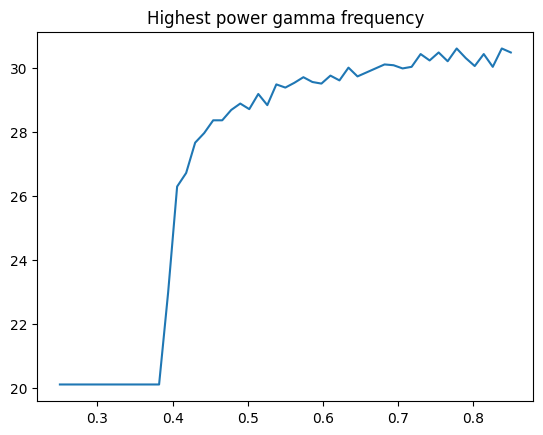

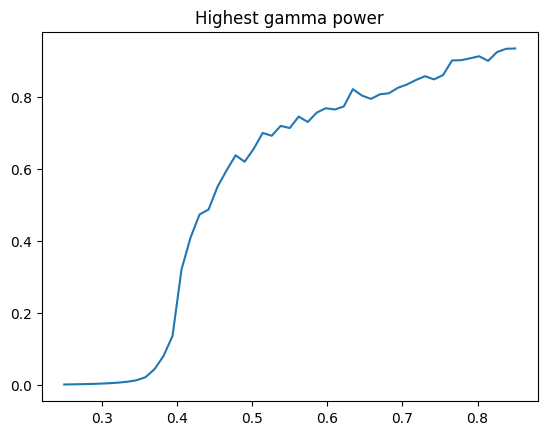

In [21]:
plt.plot(I,freq)
plt.title("Highest power gamma frequency")
plt.show()
plt.plot(I,pow)
plt.title("Highest gamma power")
plt.show()

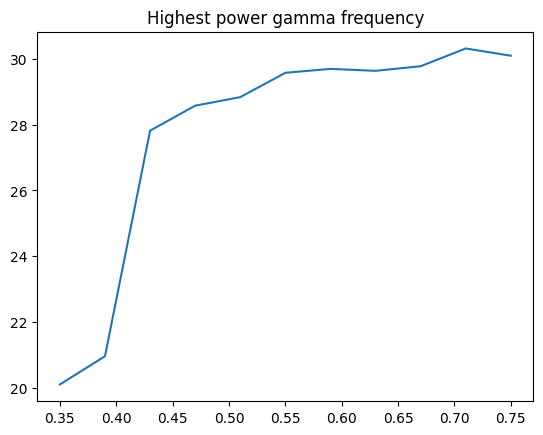

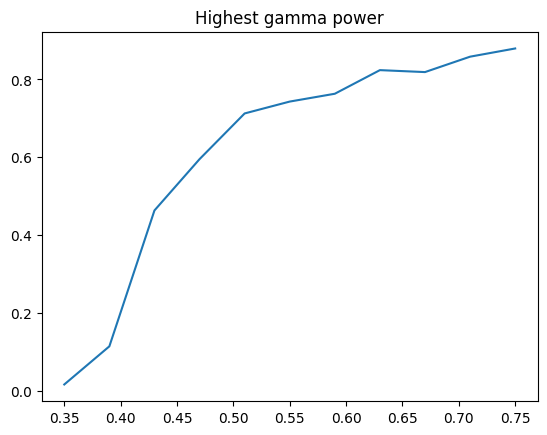

In [19]:
plt.plot(I,freq)
plt.title("Highest power gamma frequency")
plt.show()
plt.plot(I,pow)
plt.title("Highest gamma power")
plt.show()